In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
import pandas as pd

from pylab import rcParams
from wordcloud import WordCloud
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

rcParams['figure.figsize'] = 30, 60
%matplotlib inline

##Importar datos desde kaggle

In [2]:
!pip install -q kaggle

In [3]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"julianorganista10","key":"ace01503f4cffff047b63c36d1d40c81"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d olistbr/brazilian-ecommerce

 96% 41.0M/42.7M [00:00<00:00, 53.4MB/s]
100% 42.7M/42.7M [00:00<00:00, 51.7MB/s]


In [6]:
!kaggle datasets download -d olistbr/marketing-funnel-olist

  0% 0.00/278k [00:00<?, ?B/s]
100% 278k/278k [00:00<00:00, 101MB/s]


### Descomprimir los datos

In [7]:
import zipfile

In [8]:
zip_ref = zipfile.ZipFile('brazilian-ecommerce.zip', 'r')
zip_ref.extractall('Data/brazilian-ecommerce')
zip_ref.close()

In [9]:
zip_ref = zipfile.ZipFile('marketing-funnel-olist.zip', 'r')
zip_ref.extractall('Data/marketing-funnel-olist')
zip_ref.close()

### Lectura de los datasets

In [10]:
print('### Brazilian E-Commerce Public Dataset by Olist ###')
for idx, file in enumerate(os.listdir('Data/brazilian-ecommerce')):
    print(idx, '-', file)

### Brazilian E-Commerce Public Dataset by Olist ###
0 - olist_orders_dataset.csv
1 - olist_geolocation_dataset.csv
2 - olist_order_items_dataset.csv
3 - olist_customers_dataset.csv
4 - olist_products_dataset.csv
5 - olist_order_reviews_dataset.csv
6 - olist_sellers_dataset.csv
7 - olist_order_payments_dataset.csv
8 - product_category_name_translation.csv


In [11]:
df_or = pd.read_csv('Data/brazilian-ecommerce/olist_order_reviews_dataset.csv')
df_or.review_creation_date = pd.to_datetime(df_or.review_creation_date)
df_or.review_answer_timestamp = pd.to_datetime(df_or.review_answer_timestamp)
print(len(df_or))
df_or.head()

100000


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


## EDA

Se explora la distribución del número de palabras en las revisiones no vacias.

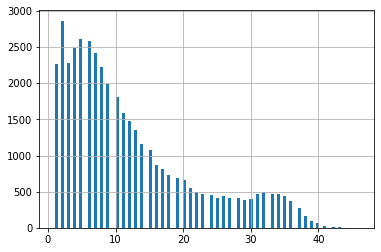

In [12]:
#words_per_review = df_or.review_comment_message.apply(lambda x: 0 if np.isnan(x) else len(x.split(" ")))
words_per_review = df_or.review_comment_message[df_or.review_comment_message.notna()].apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
#lambda x: x*2 if x < 3 else x

In [13]:
df_or_count = df_or[['review_score', 'review_id', 'review_comment_title', 'review_comment_message']].groupby(['review_score']).count()
df_or_count

,review_id,review_comment_title,review_comment_message
review_score,,,
1,11858,1957,9179
2,3235,494,2229
3,8287,843,3665
4,19200,1743,6034
5,57420,6678,20646


In [14]:
percent_val = 100 * df_or_count.review_comment_message/df_or.shape[0]
percent_val[0] = 100 - sum(percent_val)
percent_val

review_score
1     9.179
2     2.229
3     3.665
4     6.034
5    20.646
0    58.247
Name: review_comment_message, dtype: float64

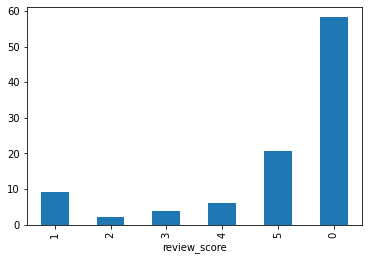

In [15]:
percent_val.plot.bar()

In [16]:
df_or.loc[df_or.review_score.notna(),'review_sentiment'] = np.where(df_or.loc[df_or.review_score.notna(),'review_score'] > 3, 1, 0)
df_or['review_sentiment'].value_counts()

1    76620
0    23380
Name: review_sentiment, dtype: int64

In [17]:
rcParams['figure.figsize'] = 30, 60

def word_cloud_rating(df,sentiment):
    
    df_filtered = df[df.review_sentiment == sentiment] #filtro por sentimiento
    Reviews = df_filtered.review_comment_message

    Reviews_text = ' '.join(Reviews.values) #Union de todas las palabras

    # Creacion de la nube de palabras
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",\
                          scale = 10,width=800, height=400).generate(Reviews_text)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

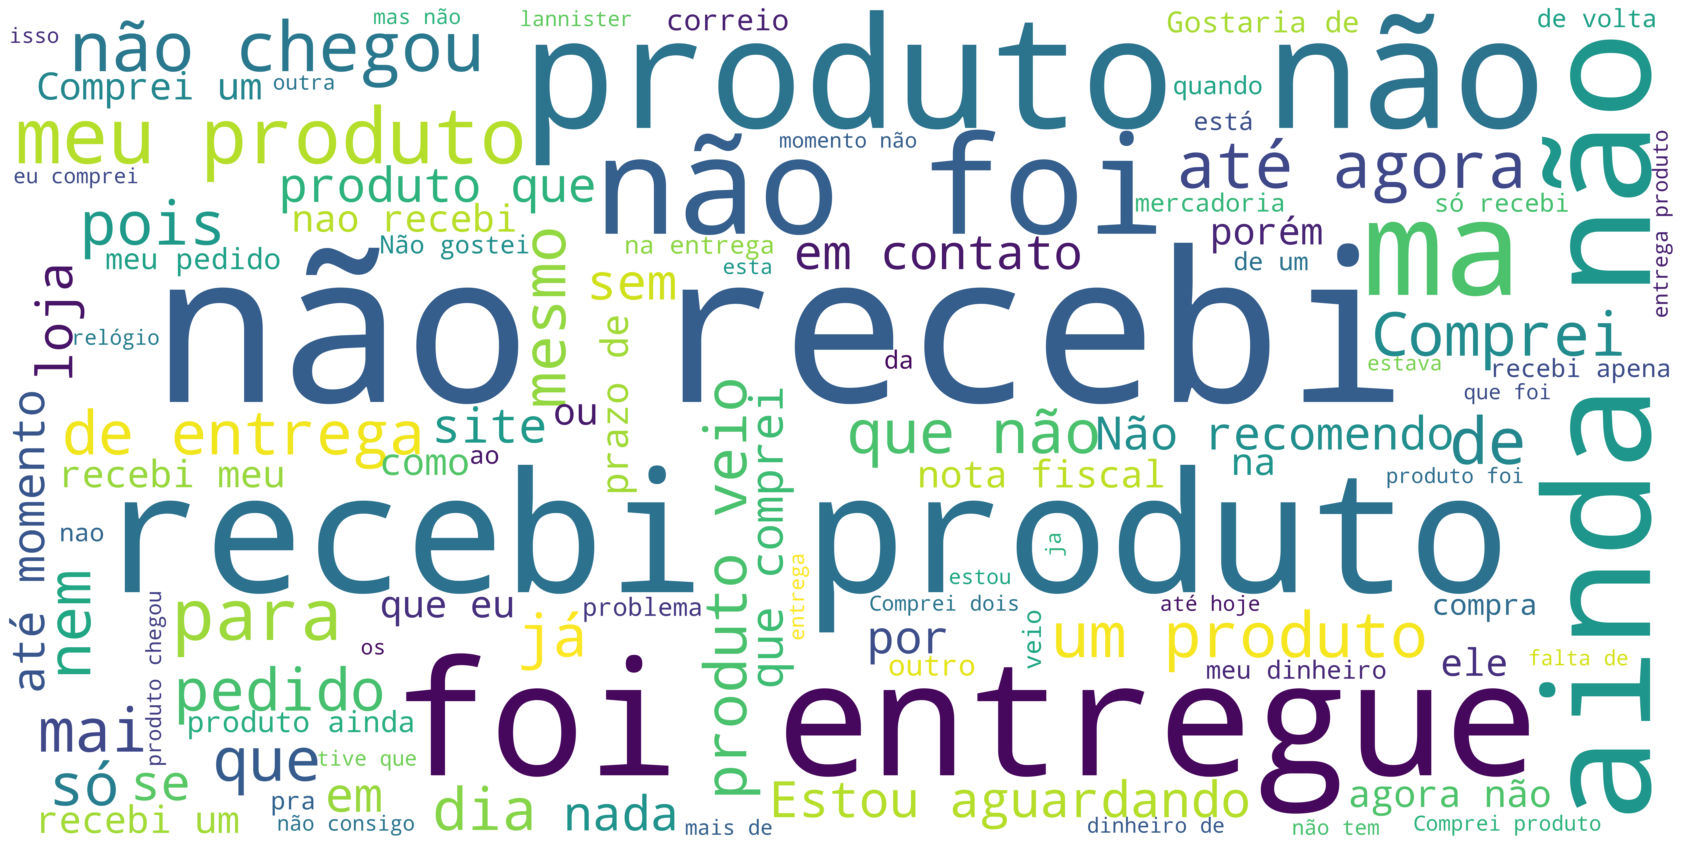

In [18]:
word_cloud_rating(df_or[(df_or.review_score != 3) & (df_or.review_comment_message.notna())], 0)

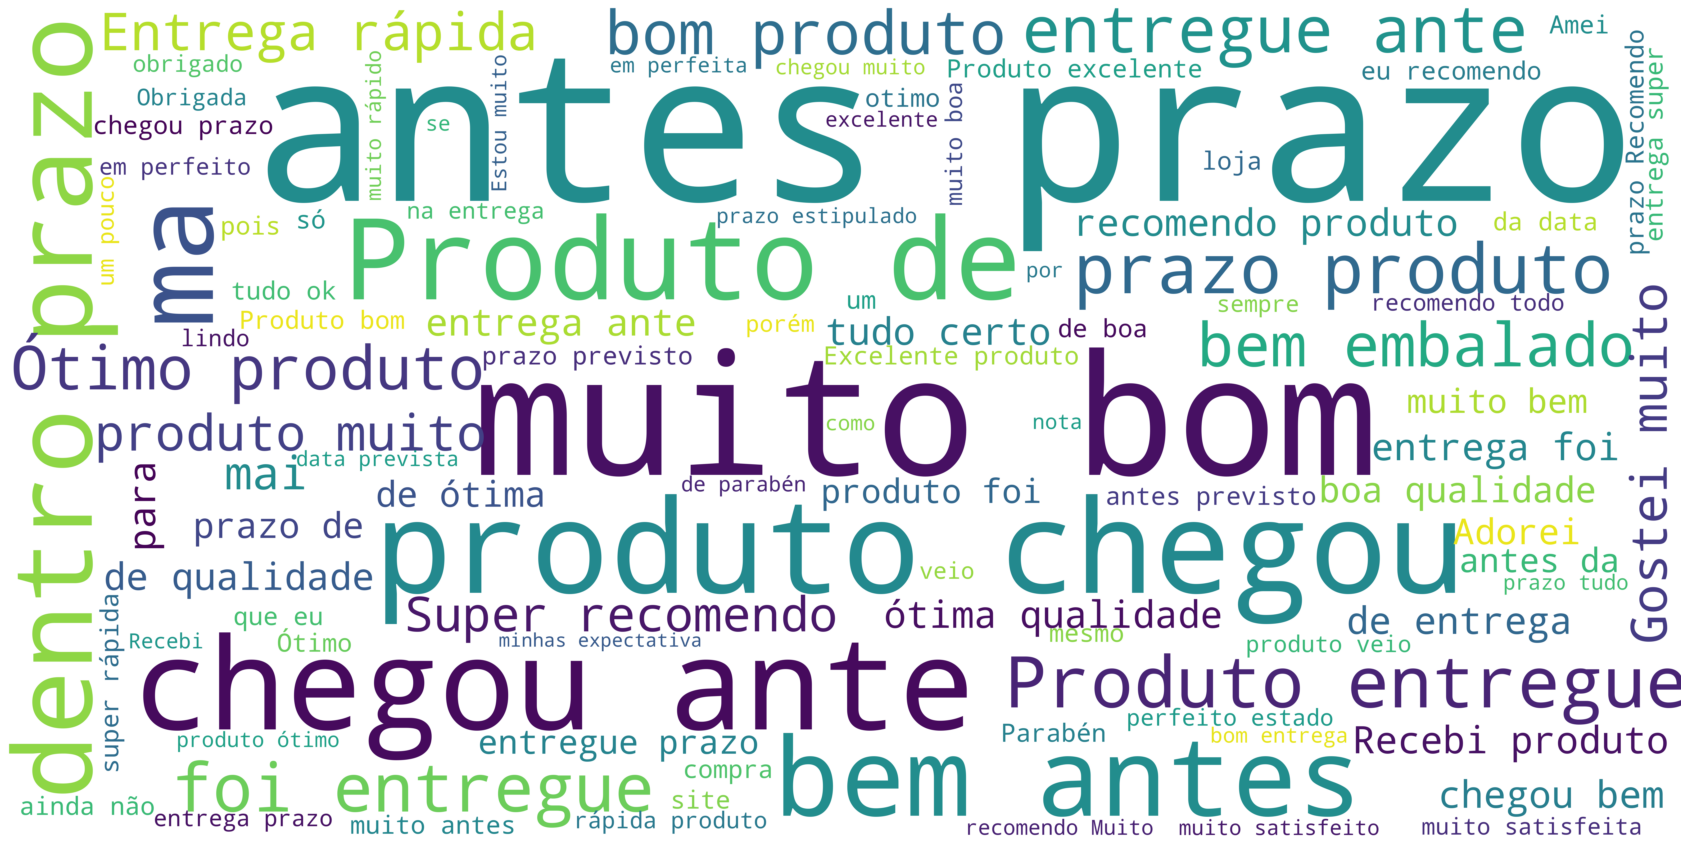

In [19]:
word_cloud_rating(df_or[(df_or.review_score != 3) & (df_or.review_comment_message.notna())], 1)

## Preprocesamiento

### Seleccion de sentimientos positivos y negativos

Se escogen unicamente los puntajes significativos, para este caso los puntajes de 1 y 2 representan sentimientos negativos y los puntajes 4 y 5 sentimientos positivos.

In [20]:
df_or = df_or[(df_or.review_score != 3) & (df_or.review_comment_message.notna())]
len(df_or)

38088

In [21]:
df_or['review_comment_message_1'] = df_or.review_comment_message.apply(lambda x: x.lower())

### Tratamiento de caracteres especiales

In [22]:
special_chars = df_or.review_comment_message_1.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])
flat_list = [item for sublist in special_chars for item in sublist]

print(set(flat_list))

{'😐', '=', '🎁', '👆', '$', '🏇', '~', '`', '😠', '💞', '!', '\\', '🐘', '×', '÷', '📺', '👌', '/', '#', '%', '💝', ',', '😘', '👉', '😢', '😓', '😀', '😣', '🤔', '´', ')', '*', '😤', '😡', ';', '💅', '😁', '💟', ']', '💯', '>', '🏾', '😊', '🏽', '_', '"', '😩', '💖', '|', '.', '🔝', '😕', '😃', '💓', '[', '🐕', '🙏', '🙌', '@', '(', '¡', '😔', '😂', '😚', '💕', '😭', '👍', '💋', '😱', '👎', '😒', '🖒', '🚚', '-', '😍', '👐', '\n', '+', '\t', '😟', '👊', '👏', '^', '💚', '😄', '😉', '🌟', '👧', '&', "'", '🙁', '°', '😞', '😥', '🍀', '?', ':', '🤙', '\r', '🏻', '😎', '😏', '<', '🏼', '😆', '🌷', '🤗'}


In [23]:
temp = list(set(flat_list)) 
temp.sort()
print(temp)

['\t', '\n', '\r', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '|', '~', '¡', '°', '´', '×', '÷', '🌟', '🌷', '🍀', '🎁', '🏇', '🏻', '🏼', '🏽', '🏾', '🐕', '🐘', '👆', '👉', '👊', '👌', '👍', '👎', '👏', '👐', '👧', '💅', '💋', '💓', '💕', '💖', '💚', '💝', '💞', '💟', '💯', '📺', '🔝', '🖒', '😀', '😁', '😂', '😃', '😄', '😆', '😉', '😊', '😍', '😎', '😏', '😐', '😒', '😓', '😔', '😕', '😘', '😚', '😞', '😟', '😠', '😡', '😢', '😣', '😤', '😥', '😩', '😭', '😱', '🙁', '🙌', '🙏', '🚚', '🤔', '🤗', '🤙']


In [24]:
import re
df_or['review_comment_message_2'] = df_or.review_comment_message_1.apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)
) 

In [25]:
print(df_or.review_comment_message[12])
print(df_or.review_comment_message_2[12])

Mas um pouco ,travando...pelo valor ta Boa.

mas um pouco  travando pelo valor ta boa 


In [26]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')

token_lists = [word_tokenize(each) for each in df_or.review_comment_message]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens con mayusculas: ", len(set(tokens)))

token_lists = [word_tokenize(each) for each in df_or.review_comment_message_1]
tokens_1 = [item for sublist in token_lists for item in sublist]
print("Numero de tokens con minusculas: ", len(set(tokens)))

token_lists = [word_tokenize(each) for each in df_or.review_comment_message_2]
tokens_2 = [item for sublist in token_lists for item in sublist]
print("Numero de tokens sin caracteres especiales: ", len(set(tokens)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Numero de tokens con mayusculas:  22051
Numero de tokens con minusculas:  22051
Numero de tokens sin caracteres especiales:  22051


### Tratamiento de Stop Words

In [27]:
nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
stop_words = stopwords_corpus.words('portuguese')
noise_words.extend(stop_words)
print(len(noise_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
204


In [28]:
print(noise_words)

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

In [29]:
one_percentile = int(len(set(tokens_1)) * 0.01)
top_1_percentile_1 = Counter(tokens_1).most_common(one_percentile)

one_percentile = int(len(set(tokens_2)) * 0.01)
top_1_percentile_2 = Counter(tokens_2).most_common(one_percentile)

In [30]:
print(len(top_1_percentile_2))
print(top_1_percentile_2)

143
[('o', 33158), ('produto', 17223), ('e', 15229), ('a', 11645), ('de', 10540), ('do', 10474), ('n', 10175), ('prazo', 8048), ('muito', 7528), ('que', 7496), ('entrega', 6176), ('antes', 5495), ('com', 5414), ('chegou', 5274), ('recebi', 4903), ('no', 4746), ('bom', 4247), ('recomendo', 4241), ('foi', 4236), ('um', 3859), ('entregue', 3593), ('da', 3229), ('em', 3226), ('s', 3181), ('bem', 2925), ('para', 2873), ('veio', 2805), ('na', 2708), ('qualidade', 2639), ('comprei', 2573), ('mas', 2469), ('uma', 2458), ('r', 2451), ('loja', 2294), ('eu', 2243), ('tudo', 2232), ('ainda', 2111), ('compra', 2102), ('por', 2058), ('meu', 2029), ('m', 2019), ('mais', 1819), ('estou', 1817), ('timo', 1793), ('excelente', 1785), ('gostei', 1742), ('super', 1710), ('at', 1695), ('como', 1623), ('as', 1512), ('me', 1443), ('os', 1409), ('pida', 1376), ('dentro', 1345), ('minha', 1306), ('j', 1280), ('pedido', 1279), ('lannister', 1250), ('dia', 1240), ('nao', 1221), ('boa', 1204), ('produtos', 1147), 

In [31]:
print(len(top_1_percentile_1))
print(top_1_percentile_1)

177
[('.', 27328), (',', 20623), ('o', 17152), ('produto', 17126), ('e', 14925), ('a', 11046), ('de', 10521), ('do', 10438), ('!', 10287), ('não', 9841), ('prazo', 7936), ('que', 7491), ('muito', 7483), ('entrega', 6112), ('antes', 5487), ('chegou', 5240), ('com', 5226), ('recebi', 4890), ('no', 4731), ('foi', 4221), ('bom', 4214), ('recomendo', 4148), ('é', 3991), ('um', 3848), ('entregue', 3579), ('em', 3215), ('da', 3194), ('bem', 2910), ('para', 2872), ('veio', 2797), ('na', 2697), ('qualidade', 2606), ('comprei', 2557), ('uma', 2447), ('mas', 2437), ('...', 2328), ('loja', 2268), ('eu', 2231), ('tudo', 2220), ('ainda', 2098), ('compra', 2080), ('meu', 2020), ('mais', 1808), ('estou', 1785), ('excelente', 1771), ('ótimo', 1764), ('gostei', 1723), ('até', 1690), ('super', 1681), ('como', 1612), ('só', 1549), ('me', 1419), ('rápida', 1357), ('dentro', 1342), ('as', 1313), ('minha', 1298), ('por', 1290), ('os', 1275), ('pedido', 1266), ('já', 1260), ('dia', 1222), ('nao', 1204), ('boa

In [32]:
bottom_1_percentile = Counter(tokens_1).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('preparadas', 1),
 ('enderços', 1),
 ('001063', 1),
 ('estufa', 1),
 ('de.um', 1),
 ('nt', 1),
 ('18.09.2017', 1),
 ('mochila.obrigada', 1),
 ('precário', 1),
 ('daquela', 1)]

In [33]:
#noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

In [34]:
words_no_stopwords = ['não', 'sim', 'muito','se','mais','quando','só','pelo','até','depois',
                      'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 
                      'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 
                      'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 
                      'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']
for word in words_no_stopwords:
  if word in noise_words: noise_words.remove(word)

In [35]:
# df_or.to_csv('Data/brazilian-ecommerce/olist_order_reviews_clean_dataset.csv',sep=',',index=False,encoding='utf-8')
with open('Data/brazilian-ecommerce/olist_order_reviews_clean_dataset.csv', mode='w', newline='\n') as f:
           df_or.to_csv(f, sep=',', float_format='%.2f',index=False, line_terminator='\r')

## EDA ngramas

In [36]:
# Following code grabbed from:
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
# we will use it in our context to create some visualizations.
def get_top_n_words(corpus, n=1,k=1,stop_words = 'portuguese'):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

```df_or.review_comment_message```: Columna con texto original

```df_or.review_comment_message_1```: Columna con texto en minuscula

```df_or.review_comment_message_2```: Columna con texto en minuscula y sin caracteres especiales

### 1-grama

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00x2', '04', '09', '10', '11', '12', '14', '15', '16', '18', '2017', '2017041515074', '2018', '21', '25', '257', '80', '87', 'acesso', 'amei', 'bg2024', 'bom', 'celta', 'competente', 'condições', 'decepcionada', 'duas', 'dá', 'embalado', 'errado', 'frustrada', 'guardá', 'imaginava', 'instalei', 'junto', 'lo', 'ls3004', 'maravilhoso', 'meriva', 'mochila', 'não', 'obrigada', 'obrigado', 'pensei', 'portanto', 'prazo', 'prisma', 'produto', 'qt4015', 'queria', 'recebi', 'residência', 'rápido', 'segurança', 'super', 'tive', 'tratado', 'ótimo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


produto 17223
não 9877
prazo 8048
muito 7528
entrega 6176
antes 5495
chegou 5274
recebi 4903
bom 4247
recomendo 4241
entregue 3593
bem 2925
veio 2805
qualidade 2639
comprei 2573
loja 2294
tudo 2232
ainda 2111
compra 2101
mais 1819


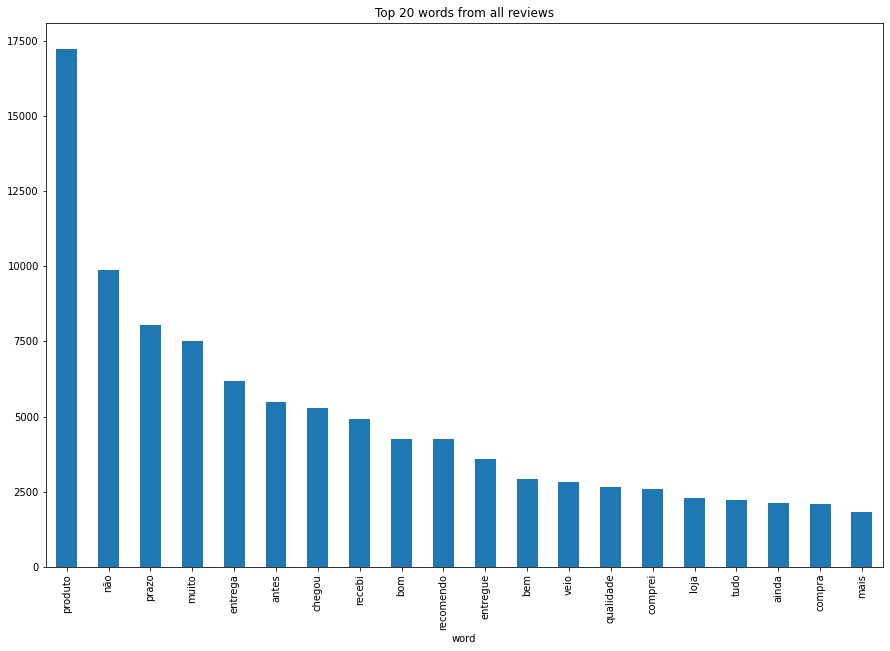

In [37]:
rcParams['figure.figsize'] = 15, 10

common_words = get_top_n_words(df_or.review_comment_message_1, 20,1,noise_words)
for word, freq in common_words:
    print(word, freq)
df_1grama_common = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_1grama_common.groupby('word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 20 words from all reviews')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00x2', '04', '09', '10', '11', '12', '14', '15', '16', '18', '2017', '2017041515074', '2018', '21', '25', '257', '80', '87', 'acesso', 'amei', 'bg2024', 'bom', 'celta', 'competente', 'condições', 'decepcionada', 'duas', 'dá', 'embalado', 'errado', 'frustrada', 'guardá', 'imaginava', 'instalei', 'junto', 'lo', 'ls3004', 'maravilhoso', 'meriva', 'mochila', 'não', 'obrigada', 'obrigado', 'pensei', 'portanto', 'prazo', 'prisma', 'produto', 'qt4015', 'queria', 'recebi', 'residência', 'rápido', 'segurança', 'super', 'tive', 'tratado', 'ótimo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


produto 6494
recebi 3424
comprei 1982
veio 1603
entrega 1502
ainda 1452
entregue 1410
at 1256
chegou 1239
nao 1002
compra 974
muito 951
prazo 947
pedido 877
mais 862
dia 812
loja 810
se 734
agora 728
est 637


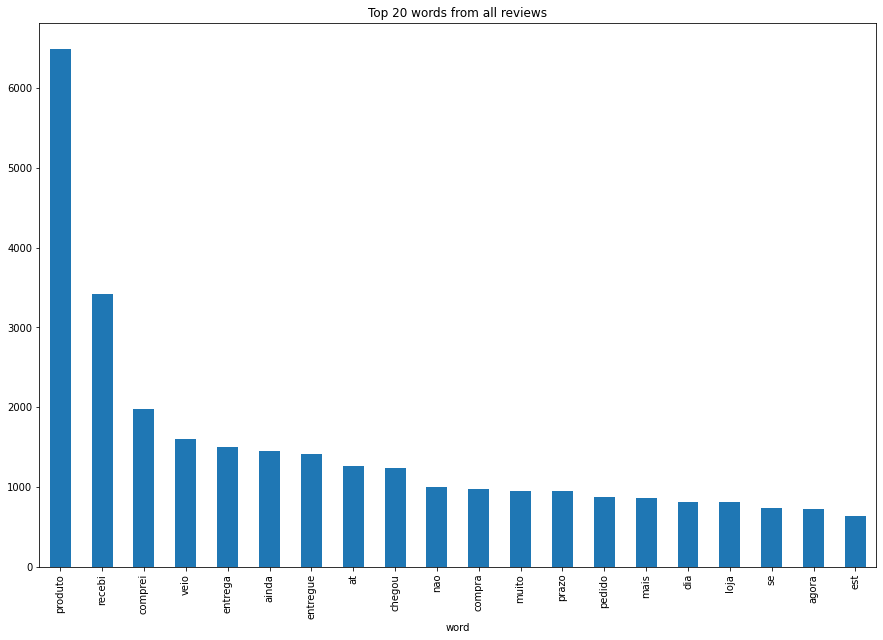

In [38]:
common_words = get_top_n_words(df_or.review_comment_message_2[df_or.review_sentiment == 0], 20,1,noise_words)
for word, freq in common_words:
    print(word, freq)
df_1grama_bad = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_1grama_bad.groupby('word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 20 words from all reviews')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00x2', '04', '09', '10', '11', '12', '14', '15', '16', '18', '2017', '2017041515074', '2018', '21', '25', '257', '80', '87', 'acesso', 'amei', 'bg2024', 'bom', 'celta', 'competente', 'condições', 'decepcionada', 'duas', 'dá', 'embalado', 'errado', 'frustrada', 'guardá', 'imaginava', 'instalei', 'junto', 'lo', 'ls3004', 'maravilhoso', 'meriva', 'mochila', 'não', 'obrigada', 'obrigado', 'pensei', 'portanto', 'prazo', 'prisma', 'produto', 'qt4015', 'queria', 'recebi', 'residência', 'rápido', 'segurança', 'super', 'tive', 'tratado', 'ótimo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


produto 10729
prazo 7101
muito 6577
antes 5295
entrega 4674
chegou 4035
bom 4022
recomendo 3883
bem 2706
entregue 2183
qualidade 2172
tudo 2103
timo 1778
excelente 1772
super 1631
loja 1484
recebi 1479
gostei 1472
pida 1350
veio 1202


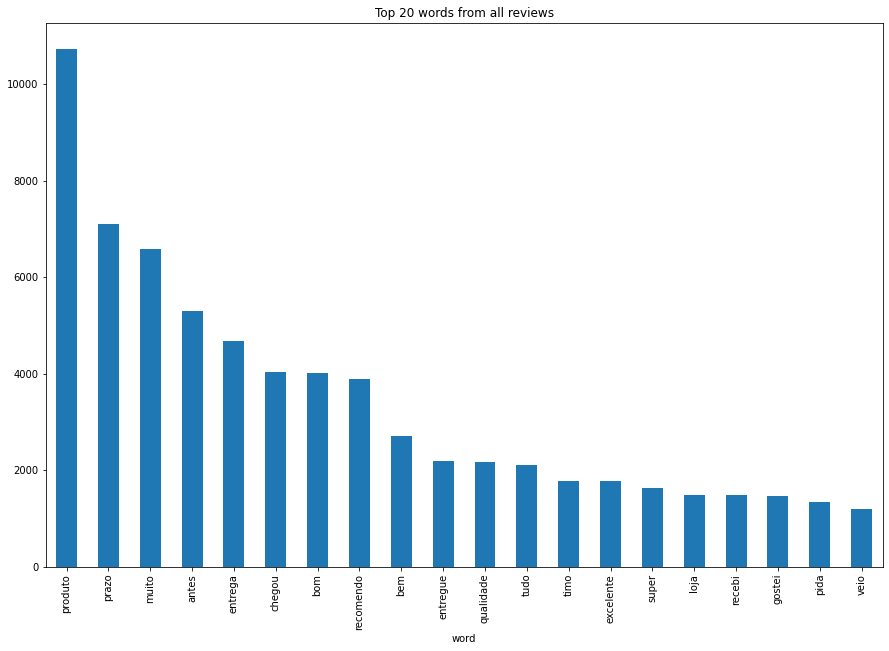

In [39]:
common_words = get_top_n_words(df_or.review_comment_message_2[df_or.review_sentiment == 1], 20,1,noise_words)
for word, freq in common_words:
    print(word, freq)
df_1grama_good = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_1grama_good.groupby('word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 20 words from all reviews')

### 2-grama

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00x2', '04', '09', '10', '11', '12', '14', '15', '16', '18', '2017', '2017041515074', '2018', '21', '25', '257', '80', '87', 'acesso', 'amei', 'bg2024', 'bom', 'celta', 'competente', 'condições', 'decepcionada', 'duas', 'dá', 'embalado', 'errado', 'frustrada', 'guardá', 'imaginava', 'instalei', 'junto', 'lo', 'ls3004', 'maravilhoso', 'meriva', 'mochila', 'não', 'obrigada', 'obrigado', 'pensei', 'portanto', 'prazo', 'prisma', 'produto', 'qt4015', 'queria', 'recebi', 'residência', 'rápido', 'segurança', 'super', 'tive', 'tratado', 'ótimo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


antes prazo 4111
muito bom 2393
recebi produto 1776
não recebi 1765
produto chegou 1453
chegou antes 1320
produto entregue 1250
ainda não 1100
dentro prazo 1003
produto não 962
bem antes 947
entrega rápida 729
entregue antes 665
produto muito 644
bem embalado 639
gostei muito 618
produto veio 615
prazo entrega 610
super recomendo 602
ótimo produto 600


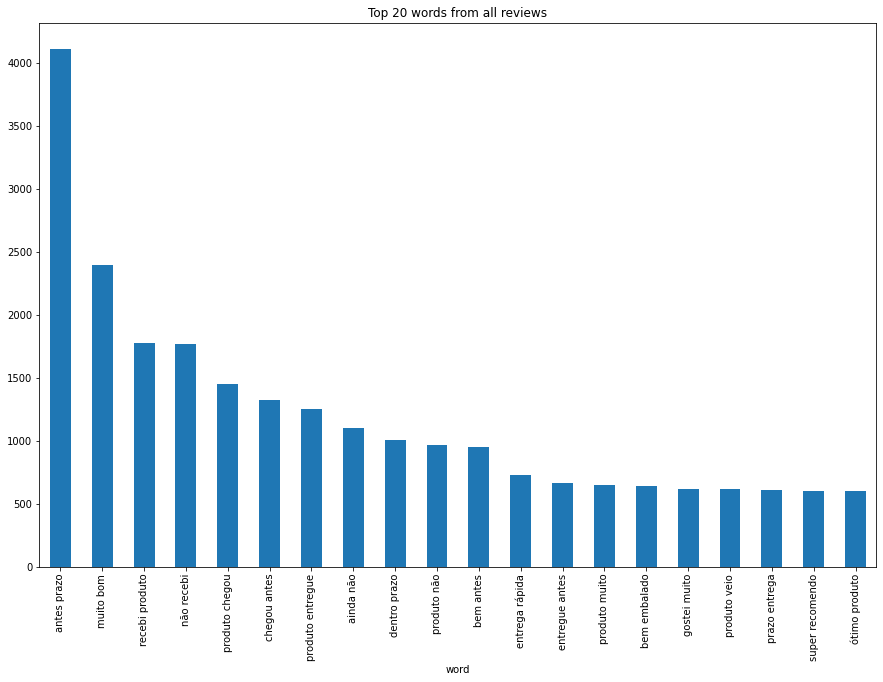

In [40]:
common_words = get_top_n_words(df_or.review_comment_message_1, 20,2,noise_words)
for word, freq in common_words:
    print(word, freq)
df_2grama_common = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_2grama_common.groupby('word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 20 words from all reviews')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00x2', '04', '09', '10', '11', '12', '14', '15', '16', '18', '2017', '2017041515074', '2018', '21', '25', '257', '80', '87', 'acesso', 'amei', 'bg2024', 'bom', 'celta', 'competente', 'condições', 'decepcionada', 'duas', 'dá', 'embalado', 'errado', 'frustrada', 'guardá', 'imaginava', 'instalei', 'junto', 'lo', 'ls3004', 'maravilhoso', 'meriva', 'mochila', 'não', 'obrigada', 'obrigado', 'pensei', 'portanto', 'prazo', 'prisma', 'produto', 'qt4015', 'queria', 'recebi', 'residência', 'rápido', 'segurança', 'super', 'tive', 'tratado', 'ótimo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


antes prazo 4030
muito bom 2368
chegou antes 1299
produto chegou 1296
produto entregue 1074
bem antes 935
parab ns 932
dentro prazo 924
entrega pida 716
entregue antes 663
bem embalado 632
timo produto 602
gostei muito 598
super recomendo 594
produto muito 578
recebi produto 515
chegou bem 507
tima qualidade 490
entrega antes 477
tudo certo 470


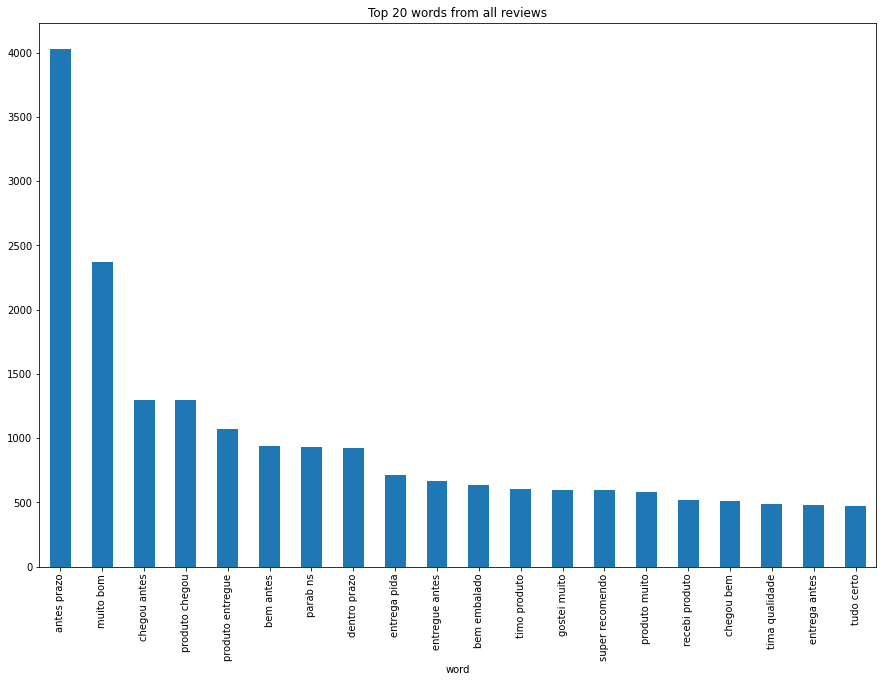

In [41]:
common_words = get_top_n_words(df_or.review_comment_message_2[df_or.review_sentiment == 1], 20,2,noise_words)
for word, freq in common_words:
    print(word, freq)
df_2grama_good = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_2grama_good.groupby('word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 20 words from all reviews')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00x2', '04', '09', '10', '11', '12', '14', '15', '16', '18', '2017', '2017041515074', '2018', '21', '25', '257', '80', '87', 'acesso', 'amei', 'bg2024', 'bom', 'celta', 'competente', 'condições', 'decepcionada', 'duas', 'dá', 'embalado', 'errado', 'frustrada', 'guardá', 'imaginava', 'instalei', 'junto', 'lo', 'ls3004', 'maravilhoso', 'meriva', 'mochila', 'não', 'obrigada', 'obrigado', 'pensei', 'portanto', 'prazo', 'prisma', 'produto', 'qt4015', 'queria', 'recebi', 'residência', 'rápido', 'segurança', 'super', 'tive', 'tratado', 'ótimo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


recebi produto 1266
at agora 445
produto entregue 439
ainda recebi 401
produto veio 376
produto chegou 310
at momento 276
nota fiscal 261
prazo entrega 244
nao recebi 243
comprei produto 236
produto ainda 227
recebi apenas 214
rel gio 195
comprei dois 175
at hoje 166
dinheiro volta 160
fiz compra 144
entrega produto 143
gostaria saber 126


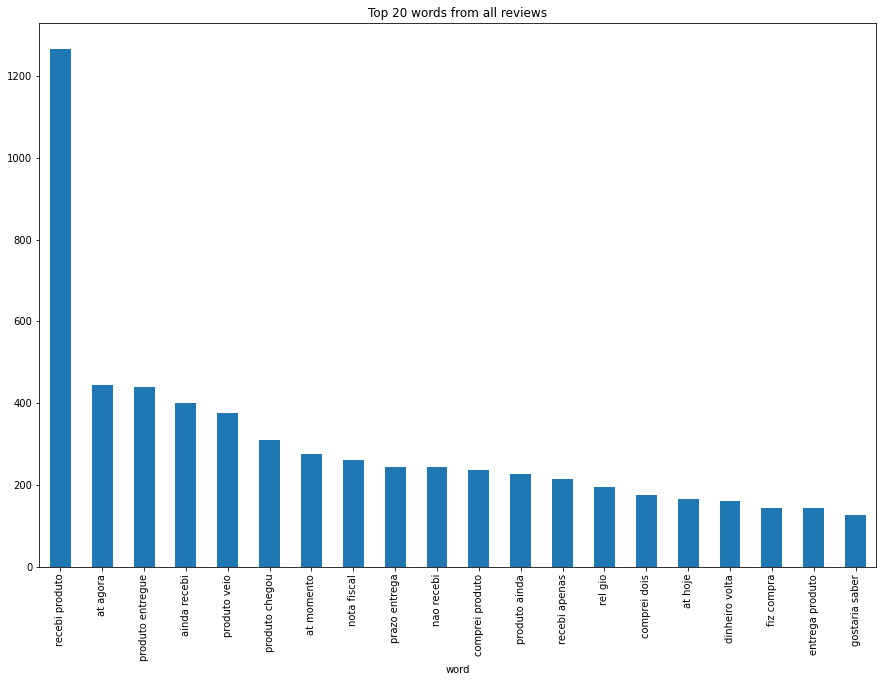

In [42]:
common_words = get_top_n_words(df_or.review_comment_message_2[df_or.review_sentiment == 0], 20,2,noise_words)
for word, freq in common_words:
    print(word, freq)
df_2grama_bad = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_2grama_bad.groupby('word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 20 words from all reviews')

### 3-grama

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00x2', '04', '09', '10', '11', '12', '14', '15', '16', '18', '2017', '2017041515074', '2018', '21', '25', '257', '80', '87', 'acesso', 'amei', 'bg2024', 'bom', 'celta', 'competente', 'condições', 'decepcionada', 'duas', 'dá', 'embalado', 'errado', 'frustrada', 'guardá', 'imaginava', 'instalei', 'junto', 'lo', 'ls3004', 'maravilhoso', 'meriva', 'mochila', 'não', 'obrigada', 'obrigado', 'pensei', 'portanto', 'prazo', 'prisma', 'produto', 'qt4015', 'queria', 'recebi', 'residência', 'rápido', 'segurança', 'super', 'tive', 'tratado', 'ótimo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


chegou antes prazo 1011
não recebi produto 878
bem antes prazo 691
entregue antes prazo 556
ainda não recebi 417
chegou bem antes 408
produto chegou antes 406
entrega antes prazo 403
produto muito bom 402
produto entregue antes 344
entrega super rápida 290
antes prazo previsto 280
produto não entregue 262
produto ótima qualidade 252
até agora não 227
muito antes prazo 225
antes prazo produto 219
entregue dentro prazo 209
antes data prevista 209
produto boa qualidade 204


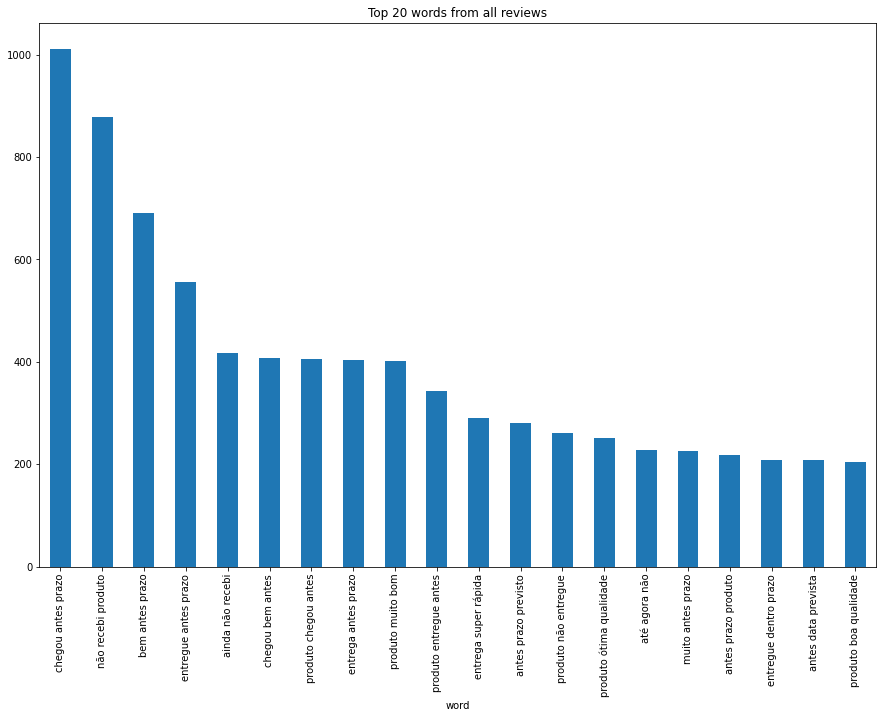

In [43]:
common_words = get_top_n_words(df_or.review_comment_message_1, 20,3,noise_words)
for word, freq in common_words:
    print(word, freq)
df_3grama_common = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_3grama_common.groupby('word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 20 words from all reviews')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00x2', '04', '09', '10', '11', '12', '14', '15', '16', '18', '2017', '2017041515074', '2018', '21', '25', '257', '80', '87', 'acesso', 'amei', 'bg2024', 'bom', 'celta', 'competente', 'condições', 'decepcionada', 'duas', 'dá', 'embalado', 'errado', 'frustrada', 'guardá', 'imaginava', 'instalei', 'junto', 'lo', 'ls3004', 'maravilhoso', 'meriva', 'mochila', 'não', 'obrigada', 'obrigado', 'pensei', 'portanto', 'prazo', 'prisma', 'produto', 'qt4015', 'queria', 'recebi', 'residência', 'rápido', 'segurança', 'super', 'tive', 'tratado', 'ótimo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


chegou antes prazo 993
bem antes prazo 681
entregue antes prazo 553
chegou bem antes 405
produto muito bom 397
entrega antes prazo 395
produto chegou antes 394
produto entregue antes 343
entrega super rápida 286
antes prazo previsto 278
produto ótima qualidade 249
muito antes prazo 221
antes prazo produto 217
antes data prevista 207
produto boa qualidade 199
entregue dentro prazo 198
muito bom produto 190
produto entregue prazo 183
antes prazo recomendo 180
recebi antes prazo 178


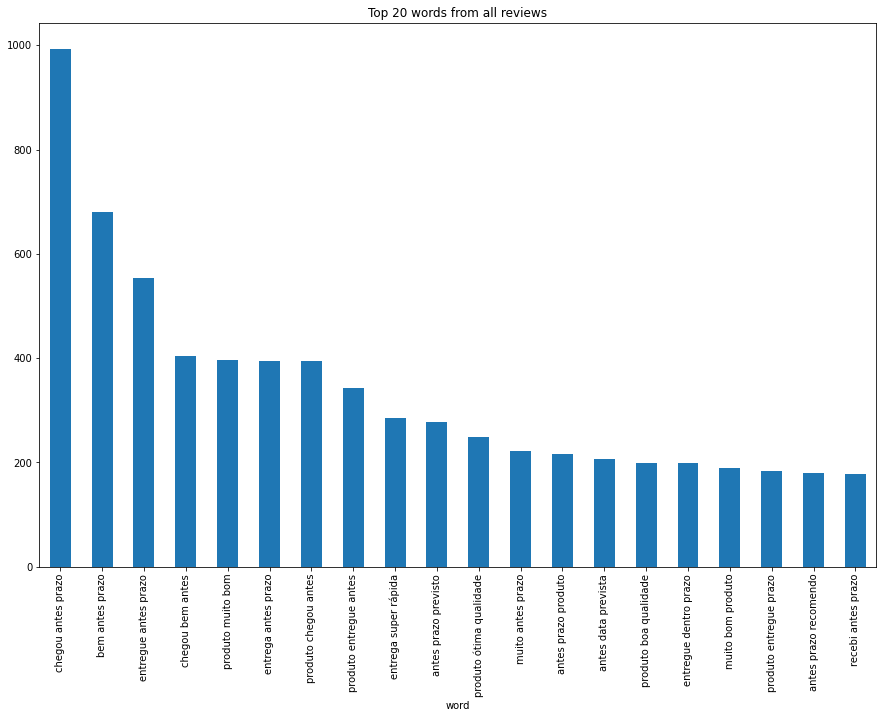

In [44]:
common_words = get_top_n_words(df_or.review_comment_message_1[df_or.review_sentiment == 1], 20,3,noise_words)
for word, freq in common_words:
    print(word, freq)
df_3grama_good = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_3grama_good.groupby('word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 20 words from all reviews')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00x2', '04', '09', '10', '11', '12', '14', '15', '16', '18', '2017', '2017041515074', '2018', '21', '25', '257', '80', '87', 'acesso', 'amei', 'bg2024', 'bom', 'celta', 'competente', 'condições', 'decepcionada', 'duas', 'dá', 'embalado', 'errado', 'frustrada', 'guardá', 'imaginava', 'instalei', 'junto', 'lo', 'ls3004', 'maravilhoso', 'meriva', 'mochila', 'não', 'obrigada', 'obrigado', 'pensei', 'portanto', 'prazo', 'prisma', 'produto', 'qt4015', 'queria', 'recebi', 'residência', 'rápido', 'segurança', 'super', 'tive', 'tratado', 'ótimo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


não recebi produto 849
ainda não recebi 388
produto não entregue 250
até agora não 214
produto ainda não 140
produto não chegou 139
até momento não 138
nao recebi produto 134
ainda não chegou 119
momento não recebi 106
agora não recebi 103
ainda não entregue 91
quero dinheiro volta 83
até agora nada 77
recebi produto não 66
ainda nao recebi 60
até hoje não 58
produto veio defeito 56
não recebi mercadoria 55
recebi produto ainda 54


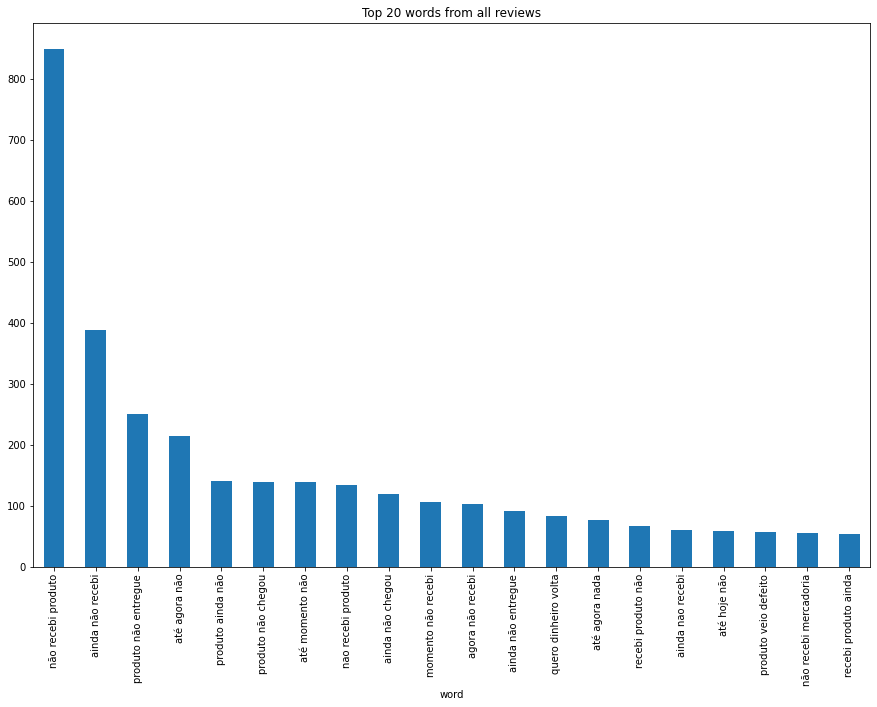

In [45]:
common_words = get_top_n_words(df_or.review_comment_message_1[df_or.review_sentiment == 0], 20,3,noise_words)
for word, freq in common_words:
    print(word, freq)
df_3grama_bad = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_3grama_bad.groupby('word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 20 words from all reviews')

## Modelo de Machine Learning

### Bag-of-words

In [46]:
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1, 1)
)

In [47]:
reviews_train, reviews_test = train_test_split(df_or, test_size=0.2, random_state=0)

In [48]:
X_train_bow = bow_counts.fit_transform(reviews_train.review_comment_message_2)
X_test_bow = bow_counts.transform(reviews_test.review_comment_message_2)
y_train_bow = reviews_train.review_sentiment
y_test_bow = reviews_test.review_sentiment

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['.', '2017041515074', '257,87'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [49]:
y_test_bow.value_counts() / y_test_bow.shape[0]

1    0.70189
0    0.29811
Name: review_sentiment, dtype: float64

In [50]:
#df_or.drop(columns=['review_comment_message_new'], inplace=True)
def confusion(ytest,y_pred):
    names=["Negative","Positive"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()
    return

#### Regresion Logistica con 1-grama

In [51]:
lr_model_all = LogisticRegression(C=1, solver="liblinear")
lr_model_all.fit(X_train_bow, y_train_bow)

test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.9453668490863556
Accuracy:  92.26831189288527


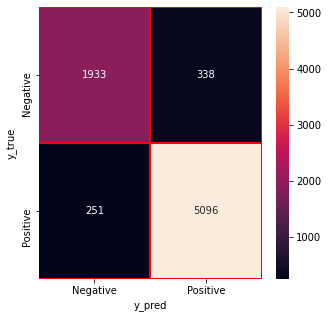

In [52]:
confusion(y_test_bow,test_pred_lr_all)

In [53]:
predictions = pd.DataFrame()
predictions['text'] = reviews_test['review_comment_message']
predictions['actual_score'] = reviews_test['review_score']
predictions['sentiment_rating'] = reviews_test['review_sentiment']
predictions['predicted_sentiment'] = test_pred_lr_all

probabilities = [each[1] for each in test_pred_lr_prob]
predictions['predicted_probability'] = probabilities

In [54]:
predictions[
    predictions['predicted_sentiment'] != predictions['sentiment_rating']
].sort_values(by=["predicted_probability"]).head(5)

,text,actual_score,sentiment_rating,predicted_sentiment,predicted_probability
33007,Somente uma SURPRESA: o produto não é american...,4,1,0,0.000021
13116,Comprei a caixa de som mais nao chegou . Voces...,4,1,0,0.000190
6257,O produto é ótimo e foi postado na data. O atr...,5,1,0,0.000272
59421,Foi me entregue 1 produto sendo que eu comprei...,4,1,0,0.000442
66627,"Eu adquiri 2 (duas) unidades do produto, mas s...",4,1,0,0.000646


In [55]:
print(predictions.text[33007])
print(predictions.text[13116])
print(predictions.text[6257])
print(predictions.text[59421])
print(predictions.text[66627])

Somente uma SURPRESA: o produto não é americano, mas, CHINÊS. Pela qualidade e semelhança não é FALSO. Porém também não é autentico. Vou usa-lo, espero que não parta o encaixe plástico prá não travar!
Comprei a caixa de som mais nao chegou . Voces falaram que iria chegar dia 18 ate agora nada. Quero que me problema seje resolvido se nao irei procurar meus direitos. 
O produto é ótimo e foi postado na data. O atraso na entrega foi culpa dos correios, que não vieram entregar, alegando que não tinha ninguém. Depois entregaram o aviso no último dia. Quase não recebi
Foi me entregue 1 produto sendo que eu comprei 2 produtos do mesmo . Ainda esperando a entrega se não ocorrerá ida a justiça.
Eu adquiri 2 (duas) unidades do produto, mas só enviaram (1) uma, porém na NFe enviada na caixa diz que foi faturado 2 (dois) produtos e foi debitado no meu cartão o valor total compra. Como resolvo?


In [56]:
predictions[
    predictions['predicted_sentiment'] != predictions['sentiment_rating']
].sort_values(by=["predicted_probability"]).tail()

,text,actual_score,sentiment_rating,predicted_sentiment,predicted_probability
7567,No quesito entrega vocês estão de parabéns. Ch...,2,0,1,0.999262
33134,"Quanto ao prazo foi tudo ótimo, só não estou s...",2,0,1,0.999473
86415,Recebi o produto muito antes do prazo.Isso é e...,1,0,1,0.999877
63025,"Eu tenho uma dúvida,pra tirar mas não sei quem...",2,0,1,0.999887
20082,"A entrega foi super rápida, está de parabéns. ...",1,0,1,0.999907


In [57]:
print(predictions.text[7567])
print(predictions.text[33134])
print(predictions.text[86415])
print(predictions.text[63025])
print(predictions.text[20082])

No quesito entrega vocês estão de parabéns. Chegou muito antes do previsto. Pena que o tablet trava muito e o sistema usa muito do espaço interno que já não é lá essas coisas.
Quanto ao prazo foi tudo ótimo, só não estou satisfeito porque paguei pelo frete para ser entregue em minha residência, mas não chegou foi para os correios. Tive que ir buscá-lo.
Recebi o produto muito antes do prazo.Isso é excelente. Muito satisfeito.
Eu tenho uma dúvida,pra tirar mas não sei quem pode me ajudar,sobre a entrega ocorreu tudo certo dentro do prazo,meus parabéns 
A entrega foi super rápida, está de parabéns. A bolsa é bonita, mas eu pensava que o material era melhor.


#### Regresion Logistica con 4-grama

In [58]:
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)

X_train_bow = bow_counts.fit_transform(reviews_train.review_comment_message_2)
X_test_bow = bow_counts.transform(reviews_test.review_comment_message_2)

In [59]:
lr_model_all_new = LogisticRegression(C=0.9, solver="liblinear")
lr_model_all_new.fit(X_train_bow, y_train_bow)

test_pred_lr_prob = lr_model_all_new.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.9514256524565803
Accuracy:  93.13468101864007


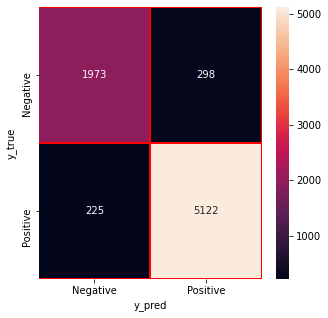

In [60]:
confusion(y_test_bow,test_pred_lr_all)

In [61]:
lr_weights = pd.DataFrame(list(
    zip(
        bow_counts.get_feature_names(),
        lr_model_all_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:15]

,words,weights
203642,excelente,2.869066
470553,timo,2.705916
425916,recomendo,2.301502
35018,amei,2.192745
341484,otimo,2.036501
249458,lindo,2.027522
27662,adorei,1.983602
361068,perfeito,1.869484
440778,satisfeito,1.838841
58716,bom,1.698457


In [62]:
lr_weights.sort_values(['weights'],ascending = False)[-15:]

,words,weights
208316,faltando,-1.458315
50127,atraso,-1.466455
127838,decepcionante,-1.493192
330434,o recomendo,-1.507083
49951,atrasada,-1.511333
362357,pessima,-1.529782
362415,pessimo,-1.554170
415902,quero,-1.566950
289594,n o recomendo,-1.610040
236316,inferior,-1.615472


In [91]:
import pickle
import joblib

pickle.dump(lr_model_all_new, open('models/linear_model.sav', 'wb'))
pickle.dump(bow_counts, open('models/vectorizer.sav', 'wb'))
#joblib.dump(bow_counts, "models/vectorizer.pkl")

In [93]:
loaded_model = pickle.load(open('models/linear_model.sav', 'rb'))
#vectorizer = joblib.load('models/vectorizer.pkl')
vectorizer = pickle.load(open('models/vectorizer.sav', 'rb'))

print("F1 score: ", f1_score(y_test_bow, loaded_model.predict(X_test_bow)))
print("Accuracy: ", accuracy_score(y_test_bow, loaded_model.predict(X_test_bow)) * 100)

F1 score:  0.9514256524565803
Accuracy:  93.13468101864007


In [94]:
pd.DataFrame(list(
    zip(
        vectorizer.get_feature_names(),
        loaded_model.coef_[0])
    ),
    columns=['words','weights']
).sort_values(['weights'],ascending = False)[:15]

,words,weights
203642,excelente,2.869066
470553,timo,2.705916
425916,recomendo,2.301502
35018,amei,2.192745
341484,otimo,2.036501
249458,lindo,2.027522
27662,adorei,1.983602
361068,perfeito,1.869484
440778,satisfeito,1.838841
58716,bom,1.698457


#### Random Forest con 4-grama

In [63]:
rf_model_all = RandomForestClassifier(n_estimators=100)

rf_model_all.fit(X_train_bow, y_train_bow)

test_pred_lr_prob = rf_model_all.predict_proba(X_test_bow)
test_pred_lr_all = rf_model_all.predict(X_test_bow)

In [64]:
print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9438789802969465
Accuracy:  92.11079023365713


In [65]:
feature_importances = pd.DataFrame(
    rf_model_all.feature_importances_,
    index=bow_counts.get_feature_names(),
    columns=['importance']
)
feature_importances.sort_values(['importance'], ascending=False)[:10]

,importance
n,0.025773
n o,0.019204
o,0.014132
recebi,0.009253
o recebi,0.007738
n o recebi,0.006959
antes do,0.005241
nao,0.005192
comprei,0.005192
um,0.004971


### TF-IDF

#### Regresion Logistica con 1-grama

In [66]:
tfidf_counts = TfidfVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1,1)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.review_comment_message_2)
X_test_tfidf = tfidf_counts.transform(reviews_test.review_comment_message_2)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['.', '2017041515074', '257,87'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [67]:
lr_model_tf_idf = LogisticRegression(solver="liblinear")
lr_model_tf_idf.fit(X_train_tfidf, y_train_bow)

test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.9490034621502761
Accuracy:  92.84589131005512


#### Regresion Logistica con 4-gramas

In [68]:
tfidf_counts = TfidfVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.review_comment_message_2)
X_test_tfidf = tfidf_counts.transform(reviews_test.review_comment_message_2)

In [69]:
# Setting up the model class
lr_model_tf_idf_new = LogisticRegression(solver="liblinear", penalty='l1', C=10)

# Training the model 
lr_model_tf_idf_new.fit(X_train_tfidf, y_train_bow)

# Prediciting the results
test_pred_lr_prob = lr_model_tf_idf_new.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf_new.predict(X_test_tfidf)

# valuating the model`
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all)*100)

F1 score:  0.9444602677299916
Accuracy:  92.32081911262799


## Graficas y elementos de Dash

In [70]:
import plotly.express as px
import plotly.graph_objects as go

### Pagina 1

#### Panel 1: etiquetas

In [71]:
df = pd.read_csv('Data/brazilian-ecommerce/olist_order_reviews_dataset.csv')

In [72]:
num_reviews = len(df)
print(f'Numero de revisiones: {num_reviews}')

Numero de revisiones: 100000


In [73]:
num_com_reviews = df.review_comment_message.count()
print(f'Numero de revisiones con comentarios: {num_com_reviews}')

Numero de revisiones con comentarios: 41753


In [74]:
perc_pos = len(df[(df.review_score == 4) | (df.review_score == 5)])/len(df)
perc_neu = len(df[(df.review_score == 3)])/len(df)
perc_neq = len(df[(df.review_score == 1) | (df.review_score == 2)])/len(df)
print('Comentarios positivos: {:.2f}%'.format(perc_pos*100))
print('Comentarios neutros: {:.2f}%'.format(perc_neu*100))
print('Comentarios positivos: {:.2f}%'.format(perc_neq*100))

Comentarios positivos: 76.62%
Comentarios neutros: 8.29%
Comentarios positivos: 15.09%


#### Panel 2: graficas

In [75]:
#df_or_count = df_or[['review_score',
#                     'review_id',
#                     'review_comment_title',
#                     'review_comment_message']].groupby(['review_score']).count()
df_or_count

,review_id,review_comment_title,review_comment_message
review_score,,,
1,11858,1957,9179
2,3235,494,2229
3,8287,843,3665
4,19200,1743,6034
5,57420,6678,20646


In [76]:
fig = go.Figure()
fig.add_trace(go.Bar(x = df_or_count.index,
                     y = df_or_count.review_id,
                     name = 'Revisiones'))
fig.add_trace(go.Bar(x = df_or_count.index,
                     y = df_or_count.review_comment_message,
                     name = 'Revisiones\ncomentadas'))
fig.update_layout(xaxis_title="Puntaje",
                  yaxis_title="Cantidad",
                  legend=dict(yanchor="top",y=0.99,xanchor="left",x=0.01)
                  )
fig.show()

In [77]:
df.review_creation_date = pd.to_datetime(df.review_creation_date)
df.review_answer_timestamp = pd.to_datetime(df.review_answer_timestamp)

In [78]:
df.loc[df.review_score.notna(),'review_sentiment'] = np.where(df.loc[df.review_score.notna(),'review_score'] > 3, 'positivo', 'negativo')
df.loc[df.review_score == 3, 'review_sentiment'] = 'neutro'
df['review_sentiment'].value_counts()

positivo    76620
negativo    15093
neutro       8287
Name: review_sentiment, dtype: int64

In [79]:
df['month_year'] = pd.to_datetime(df['review_creation_date']).dt.to_period('M')

In [80]:
df_group_date = df[['review_sentiment','month_year','review_score','review_comment_message']
                   ].groupby(['month_year','review_sentiment']).count().reset_index()
df_group_date

,month_year,review_sentiment,review_score,review_comment_message
0,2016-10,negativo,30,27
1,2016-10,neutro,14,12
2,2016-10,positivo,137,87
3,2016-11,negativo,39,36
4,2016-11,neutro,8,6
...,...,...,...,...
64,2018-07,neutro,399,174
65,2018-07,positivo,4664,1584
66,2018-08,negativo,1128,868
67,2018-08,neutro,650,294


In [81]:
fig = px.line(df_group_date, x=df_group_date['month_year'].astype(str), y="review_score", color='review_sentiment',
              labels={
                     "review_score": "Numero de revisiones",
                     "x": "Fecha",
                     "review_sentiment": "Sentimiento"
                     },
              color_discrete_sequence=['#EF553B','gray','#636EFA'])
fig.show()

#### Panel 3: n-gramas

In [82]:
fig = px.bar(df_3grama_good.sort_values(by='count'),y='word', x='count',orientation='h',
             labels={
                     "word": "n-grama",
                     "count": "Cantidad",
                     })
fig.show()

In [83]:
#df_3grama_good.sort_values(by='count')
#df_3grama_good
fig = px.bar(df_3grama_bad.sort_values(by='count'),y='word', x='count',orientation='h',
             color_discrete_sequence = ['#EF553B'],
             labels={
                     "word": "n-grama",
                     "count": "Cantidad",
                     })
fig.show()